<a href="https://colab.research.google.com/github/anirbrhm/Deep-Learning/blob/main/LargeCNN's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)

cuda:0


## Datasets, Transform and visualization

In [55]:
transform_train = transforms.Compose([
  transforms.RandomResizedCrop(224), # crops from a random area. 
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # for example of a thermal image in which the R channels might look a lot different than the other two, then the model might have
  # to learn these weights to adapt to this. But we can preprocess (mean and std dev) of the red channel to adapt to that already.                               
])

# we are not transforming the images of the datasets differently for train and test datasets but we can do it. 
# for example we can do some form of data augumentation on the training dataset (horizontal flipping etc.) for generating more samples, but not on the test dataset. 

transform_test = transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))                                     
])

In [56]:
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True,transform= transform_train)
testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True,transform= transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
num_classes = 10 

In [58]:
batch_size = 4 

In [59]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [60]:
dataiter = iter(trainloader) # create an iterator 
images, labels = dataiter.next() # gives me one instance of trainloader (4 images) 

print(images.shape) 

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
4


In [61]:
def imshow(img, title):
  npimg = img.numpy() * 0.5 + 0.5 # un-normalizing the image so that we get to see the original image 
  plt.figure(figsize=(batch_size,1))
  plt.axis("off") 
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.title(title)
  plt.show()

In [62]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

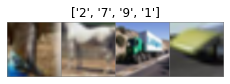

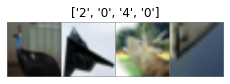

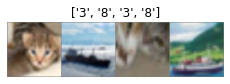

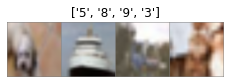

In [63]:
for i in range(4):
  show_batch_images(trainloader)

## Creating VGG-16 

In [64]:
from torchvision import models 

In [65]:
vgg = models.vgg16_bn()

In [ ]:
print(vgg)

In [67]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [68]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


To use this model for our CIFAR-10 dataset we have to modify this so that our last layer has only 10 out_features and not 1000

One approach is to specify the num_classes = 10 while initializing the model

Second approach : 

In [69]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1] # our modified classifier contains all the children of the vgg classifier except the last one (slicing)
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) # our last layer is this. 
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

## Train CIFAR-10

In [71]:
batch_size = 16 # should not use small batch sizes for training as the gradients may then be biased towards a stray data point 
# cannot also use a very large batch size for training as the GPU is not big enough to store a lot of data
# so we make them as large as it is allowed in my GPU memory 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False) # no need for shuffling  

In [72]:
def evaluation(dataloader, model):
  total , correct = 0 , 0 
  for data in dataloader:
    inputs, labels = data 
    inputs, labels = inputs.to(device), labels.to(device) 
    outputs = model(inputs) 
    _, pred = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (pred == labels).sum().item()
  return 100 * correct / total 

In [21]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

In [91]:
# import time 

# %time 

# loss_epoch_arr = []
# max_epochs = 1

# n_iters = np.ceil(50000/batch_size)

# for epoch in range(max_epochs):
#   for i, data in enumerate(trainloader, 0):
#     inputs, labels = data 
#     inputs, labels = inputs.to(device), labels.to(device)

#     opt.zero_grad()

#     outputs = vgg(inputs)
#     loss = loss_fn(outputs, labels)
#     loss.backward()
#     opt.step()

#     del inputs, labels, outputs
#     torch.cuda.empty_cache() # to ensure memory usage in the GPU is small 

#     if (i % 100) == 0:
#       print("Iteration : %d/%d, Loss : %0.2f" %(i,n_iters,loss.item()))

#   loss_epoch_arr.append(loss.item())
#   print("Epoch : %d/%d, Test acc : %0.2f, Train acc : %0.2f" %(epoch,max_epochs,evaluation(testloader, vgg),evaluation(trainloader, vgg)))

# plt.plot(loss_epoch_arr)
# plt.show() 

## Freeze Layers of Convolutional Operations

In [73]:
batch_size = 16 # should not use small batch sizes for training as the gradients may then be biased towards a stray data point 
# cannot also use a very large batch size for training as the GPU is not big enough to store a lot of data
# so we make them as large as it is allowed in my GPU memory 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False) # no need for shuffling  

In [74]:
vgg = models.vgg16_bn(pretrained=True) # already learned parameters for the IMAGENET challenge

In [75]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1] # our modified classifier contains all the children of the vgg classifier except the last one (slicing)
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) # our last layer is this. 
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [76]:
for param in vgg.parameters():
  param.requires_grad = False
# but now there will be no training , so we need some parameters to be unfrozen
# so we do that in the last layer, where we delete the present layer and add our own layer

In [77]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features,num_classes) # by default sets requires_grad = True

In [78]:
for param in vgg.parameters():
  if param.requires_grad : 
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [79]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

In [84]:
# import time 

# %time 

# loss_epoch_arr = []
# max_epochs = 1

# n_iters = np.ceil(50000/batch_size)

# for epoch in range(max_epochs):
#   for i, data in enumerate(trainloader, 0):
#     inputs, labels = data 
#     inputs, labels = inputs.to(device), labels.to(device)

#     opt.zero_grad()

#     outputs = vgg(inputs)
#     loss = loss_fn(outputs, labels)
#     loss.backward()
#     opt.step()

#     del inputs, labels, outputs
#     torch.cuda.empty_cache() # to ensure memory usage in the GPU is small 

#     if (i % 100) == 0:
#       print("Iteration : %d/%d, Loss : %0.2f" %(i,n_iters,loss.item()))

#   loss_epoch_arr.append(loss.item())
#   print("Epoch : %d/%d, Test acc : %0.2f, Train acc : %0.2f" %(epoch,max_epochs,evaluation(testloader, vgg),evaluation(trainloader, vgg)))

# plt.plot(loss_epoch_arr)
# plt.show() # we are initially reducing the loss, but then it starts increasing again. So we need some kind of checkpointing

## With model Copies

In [80]:
import copy 

In [83]:
# import time 

# %time 

# loss_epoch_arr = []
# max_epochs = 1

# min_loss = 1000

# n_iters = np.ceil(50000/batch_size)

# for epoch in range(max_epochs):
#   for i, data in enumerate(trainloader, 0):
#     inputs, labels = data 
#     inputs, labels = inputs.to(device), labels.to(device)

#     opt.zero_grad()

#     outputs = vgg(inputs)
#     loss = loss_fn(outputs, labels)
#     loss.backward()
#     opt.step()

#     del inputs, labels, outputs
#     torch.cuda.empty_cache() # to ensure memory usage in the GPU is small 

#     # checkpointing 
#     if min_loss > loss.item():
#       min_loss = loss.item()
#       best_model = copy.deepcopy(vgg.state_dict()) # deep copying the vgg state right now 
#       print("Min loss %0.2f" % min_loss)

#     if (i % 100) == 0:
#       print("Iteration : %d/%d, Loss : %0.2f" %(i,n_iters,loss.item()))

#   loss_epoch_arr.append(loss.item())
#   print("Epoch : %d/%d, Test acc : %0.2f, Train acc : %0.2f" %(epoch,max_epochs,evaluation(testloader, vgg),evaluation(trainloader, vgg)))

# plt.plot(loss_epoch_arr)
# plt.show() # we are initially reducing the loss, but then it starts increasing again. So we need some kind of checkpointing

In [42]:
vgg.load_state_dict(best_model) # loading the vgg by the best_model , we might want to do it for more epochs but this time starting from the best_model we got from this epoch
print(evaluation(trainloader,vgg), evaluation(testloader,vgg))

46.462 46.17


Our idea should be to use the best model and retrain , because we are here only looking at 16 images and so on. It might not give the best accuracy at the whole dataset. 


## ResNet Model

In [44]:
resnet = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
print(resnet)

In [46]:
for param in resnet.parameters():
  param.requires_grad =  False

In [47]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [49]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr = 0.01) 

In [ ]:
import time 

%time 

loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data 
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = resnet(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache() # to ensure memory usage in the GPU is small 

    # checkpointing 
    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict()) # deep copying the vgg state right now 
      print("Min loss %0.2f" % min_loss)

    if (i % 100) == 0:
      print("Iteration : %d/%d, Loss : %0.2f" %(i,n_iters,loss.item()))

  loss_epoch_arr.append(loss.item())
  print("Epoch : %d/%d, Test acc : %0.2f, Train acc : %0.2f" %(epoch,max_epochs,evaluation(testloader, resnet),evaluation(trainloader, resnet)))

plt.plot(loss_epoch_arr)
plt.show() 

In [51]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader,resnet), evaluation(testloader,resnet))

56.146 55.73


## Inception Model

In [81]:
inception = models.inception_v3(pretrained = True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
print(inception)

In [86]:
for param in inception.parameters():
  param.requires_grad = False

In [87]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [88]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [90]:
for param in inception.parameters():
  if param.requires_grad == True :
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [100]:
transform_train = transforms.Compose([
  transforms.RandomResizedCrop(299), # inception models requires 29x299x3 shaped images 
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) 
])

transform_test = transforms.Compose([
  transforms.RandomResizedCrop(299),
  transforms.ToTensor(),
  transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))                                     
])

In [101]:
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True,transform= transform_train) # the datasets will not be downloaded again , only transformations will be done to those
testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True,transform= transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [102]:
batch_size = 16 # should not use small batch sizes for training as the gradients may then be biased towards a stray data point 
# cannot also use a very large batch size for training as the GPU is not big enough to store a lot of data
# so we make them as large as it is allowed in my GPU memory 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False) # no need for shuffling  

In [103]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr = 0.01) 

In [104]:
def evaluation_inception(dataloader, model):
  total , correct = 0 , 0 
  for data in dataloader:
    inputs, labels = data 
    inputs, labels = inputs.to(device), labels.to(device) 
    outputs,aux_outputs = model(inputs) # onl; difference is here 
    _, pred = torch.max(outputs.data, 1) 
    total += labels.size(0) 
    correct += (pred == labels).sum().item()
  return 100 * correct / total 

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.63 µs
Min loss 2.86
Iteration : 0/3125, Loss : 2.86
Min loss 2.85
Min loss 2.82
Min loss 2.77
Min loss 2.68
Min loss 2.68
Min loss 2.65
Min loss 2.55
Iteration : 100/3125, Loss : 2.98
Min loss 2.50
Min loss 2.36
Min loss 2.36
Min loss 2.24
Iteration : 200/3125, Loss : 2.54
Min loss 2.18
Min loss 1.81
Iteration : 300/3125, Loss : 2.31
Iteration : 400/3125, Loss : 2.14
Min loss 1.71
Min loss 1.60
Iteration : 500/3125, Loss : 1.98
Iteration : 600/3125, Loss : 2.38
Min loss 1.55
Iteration : 700/3125, Loss : 2.15
Iteration : 800/3125, Loss : 2.39
Iteration : 900/3125, Loss : 1.57
Min loss 1.53
Min loss 1.52
Iteration : 1000/3125, Loss : 1.84
Min loss 1.45
Iteration : 1100/3125, Loss : 1.65
Min loss 1.42
Iteration : 1200/3125, Loss : 1.98
Iteration : 1300/3125, Loss : 2.31
Iteration : 1400/3125, Loss : 2.12
Iteration : 1500/3125, Loss : 2.22
Min loss 1.41
Min loss 1.40
Iteration : 1600/3125, Loss : 2.13
Iteration : 1700/3125, Loss

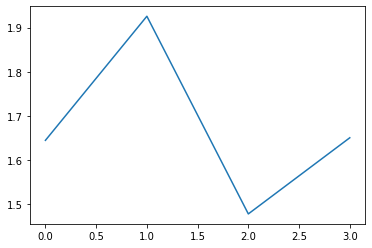

In [105]:
import time 

%time 

loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data 
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs, aux_outputs = inception(inputs)
    loss = loss_fn(outputs, labels) + 0.3* loss_fn(aux_outputs, labels) # modifying our loss function 
    loss.backward()
    opt.step()

    del inputs, labels, outputs
    torch.cuda.empty_cache() # to ensure memory usage in the GPU is small 

    # checkpointing 
    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(resnet.state_dict()) # deep copying the vgg state right now 
      print("Min loss %0.2f" % min_loss)

    if (i % 100) == 0:
      print("Iteration : %d/%d, Loss : %0.2f" %(i,n_iters,loss.item()))

  loss_epoch_arr.append(loss.item())
  print("Epoch : %d/%d, Test acc : %0.2f, Train acc : %0.2f" %(epoch,max_epochs,evaluation(testloader, resnet),evaluation(trainloader, resnet)))

plt.plot(loss_epoch_arr)
plt.show() 